<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [22]:
# system library
import os
import sys
import json

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve
from yellowbrick.target import ClassBalance

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline

# over_sampling imbalancer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import RandomOverSampler

# under_sampling imbalancer
from imblearn.under_sampling import NearMiss 
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.under_sampling import CondensedNearestNeighbour


plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

<h6> Datasets loading </h6>

In [23]:
X_train = pd.read_csv('../../data/fma_metadata/X_train_merged.csv', index_col=0)
X_test = pd.read_csv('../../data/fma_metadata/X_test.csv', index_col=0)

y_train = pd.read_csv('../../data/fma_metadata/y_train_merged.csv', index_col=0)
y_test = pd.read_csv('../../data/fma_metadata/y_test.csv', index_col=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

X_train_vt = pd.read_csv('../../data/fma_metadata/X_train_merged_vt.csv', index_col=0)
X_test_vt = pd.read_csv('../../data/fma_metadata/X_test_vt.csv', index_col=0)

print(X_train_vt.shape, X_test_vt.shape)
print(y_train.shape, y_test.shape)

(92834, 55) (10874, 55)
(92834, 1) (10874, 1)
(92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h6> Global parameters </h6>

In [24]:
n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model = DecisionTreeClassifier(random_state=random_state)
model_name = "DecisionTreeClassifier"

trails_flag = True
v_or_t_flag = "TST"
cmap = plt.cm.Blues
color = "blue"

<h6>Continous, categorical/ordinal column retrieval</h6>

In [25]:
numeric_columns = []  # continous variables
for column_name in X_train.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [26]:
categoric_columns = []  # ordinal or categorical variables
for column_name in X_train.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


In [27]:
numeric_columns_vt = set(numeric_columns).intersection(set(X_train_vt.columns))
print("numeric_columns_vt", len(numeric_columns_vt))

numeric_columns_vt 15


In [28]:
categoric_columns_vt = set(categoric_columns).intersection(set(X_train_vt.columns))
print("categoric_columns_vt", len(categoric_columns_vt))

categoric_columns_vt 13


<h6>Define current (filtered) train and test</h6>

In [29]:
X_tr = X_train
y_tr = y_train
X_ts = X_test
y_ts = y_test

X_tr_vt = X_train_vt
X_ts_vt = X_test_vt

print(X_tr.shape, X_ts.shape, X_tr_vt.shape, X_ts_vt.shape)
print(y_tr.shape, y_ts.shape)

(92834, 55) (10874, 55) (92834, 28) (10874, 28)
(92834, 1) (10874, 1)


<h6> Useful functions </h6>

In [30]:
def model_grid(X_tr):
    grid = dict()
    grid['model__criterion'] = ['gini', 'entropy']
    grid['model__max_features'] = [None, 'auto', 'sqrt', 'log2']
    grid['model__max_depth'] = [None] + list(np.arange(1, len(X_tr.columns) + 1))
    # grid['model__min_samples_split'] = [0.1, 0.01, 0.001] # ceil(min_samples_split * n_samples)
    grid['model__min_samples_split'] = [2, 5] + list(range(10, 101, 10))
    # grid['model__min_samples_split'] = list(np.arange(2, 101))
    # grid['model__min_samples_leaf'] = [0.05, 0.005, 0.0005] # ceil(min_samples_split * n_samples)
    grid['model__min_samples_leaf'] = [2, 5] + list(range(10, 101, 10))
    # grid['model__min_samples_leaf'] = list(np.arange(2, 101))
    grid['model__class_weight'] = ['balanced', None]
    return grid

In [31]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name.capitalize(), v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name.capitalize(), v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model):
    pca = PCA(n_components=2)
    best_visualisation_scaler = StandardScaler()
    scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    # X = pca.fit_transform(X_tr)
    y = y_tr.values.ravel()

    model.fit(X, y)
    plt.figure(figsize=(8, 5))
    fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
    plt.legend(loc='best', framealpha=1, shadow=True, borderpad=1)
    plt.grid(False)
    plt.show()

def spot_errors(test_label, test_pred):  
    spot_errors = []
    label_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
            label_errors.append("wrong prediction")
        else:
            spot_errors.append('darkgray')
            label_errors.append("correct prediction")
    return spot_errors, label_errors

def classification_visualizer(test_set, test_label, test_pred):
    test_label = test_label.values
    
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    errors, label_errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']
    
    for i in range(0, 3):
        axs[i].scatter(test_set[missclassif_column_name1], test_set[missclassif_column_name2], c=labels[i], cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(missclassif_column_name1, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(missclassif_column_name2, fontdict={'fontsize': 'large'})
        
    plt.suptitle('Visualization of the ' + model_name + ' classifier on the %s' % v_or_t_flag)
    plt.show()
    

def error_visualizer(test_set, test_label, test_pred, column_name1, column_name2):
    test_label = test_label.values
    errors, label_errors = spot_errors(test_label, test_pred)
    
    palette = ['darkgray', 'darkred']
    if errors[0] == 'darkred':
        palette = ['darkred', 'darkgray']
    
    fig = plt.figure(figsize=(5, 6))
    sns.scatterplot(x=test_set[column_name1], y=test_set[column_name2], hue=label_errors, palette=palette)
    plt.title('%s\'s %s misclassifications' % (model_name, v_or_t_flag))
    plt.xlabel(column_name1)
    plt.ylabel(column_name2)

    plt.legend()
    plt.show()

In [32]:
# IMBALANCE PLOT FUNCTIONS
def plot_class_balance(y_tr, x_label):
    if isinstance(y_tr, pd.core.frame.DataFrame):
        y_tr = y_tr.values.ravel()
    
    plt.figure(figsize=(8, 5))
    visualizer = ClassBalance()   # Instantiate the visualizer
    visualizer.fit(y_tr)        # Fit the data to the visualizer
    visualizer.ax.set_xlabel(x_label)
    visualizer.show()        # Finalize and render the figure
    plt.show()

def plot_examples_by_class_label(X_tr, y_tr, best_visualisation_scaler, imbalancer_name):
    # summarize class distribution
    if isinstance(y_tr, pd.core.frame.DataFrame):
        y = y_tr.values.ravel()
    else:
        y = y_tr
    counter = Counter(y)
    print(counter)
    
    pca = PCA(n_components=2)
    scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
    X = pca.fit_transform(scaled_X_tr)
    # X = pca.fit_transform(X_tr)

    model.fit(X, y)
    plt.figure(figsize=(8, 5))
    for label, _ in counter.items():
        row_ix = np.where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label), s=15)
    plt.xlabel("PCA component 1")
    plt.ylabel("PCA component 2")
    if imbalancer_name != "":
        plt.title("%s's %s %s resampling" % (model_name, v_or_t_flag, imbalancer_name))
    else:
        plt.title("%s original class labels" % (v_or_t_flag))
    plt.legend(loc='best', framealpha=1, shadow=True, borderpad=1)
    plt.grid(False)
    plt.show()

In [33]:
def get_best_features_grid_cv(X_tr, y_tr, results, key):
    
    if key == 'anova':
        best_k = results.best_params_['anova__k']
        select_k_best = SelectKBest(score_func=f_classif, k=best_k)
        fit = select_k_best.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(X_tr.columns)
    elif key == 'rfe':
        best_k = results.best_params_['rfe__n_features_to_select']
        estimator = results.best_params_['rfe__estimator']
        select_rfe = RFE(estimator=estimator, n_features_to_select=best_k)  # best_k=estimator
        fit = select_rfe.fit(X_tr, y_tr.values.ravel())
        df_scores = pd.DataFrame(fit.ranking_)
    else:
        print("wrong key=%s" % key)
        sys.exit(-1)
  
    df_columns = pd.DataFrame(X_tr.columns)
    feature_scores = pd.concat([df_columns, df_scores],axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    
    if trails_flag == False:
        # plot feature importance
        fig = plt.figure(figsize=(8, 10))
        sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                                order=ordered_k_feature_scores.features)
        plt.grid(False)
        plt.title("%s's %s feature importance using %s" % (model_name, v_or_t_flag,  key.upper()))
        plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)

    return best_features, best_features_scores

In [34]:
def get_feature_importances_or_coef(X_tr, y_tr, tuned_model):

    try:
        df_scores = pd.DataFrame(tuned_model.feature_importances_)
        best_k = tuned_model.n_features_
    except:
        try:
            df_scores = pd.DataFrame(tuned_model.coef_)

            best_k = len([x for x in list(df_scores.values)])
        except:
            print("Wrong curr_model's retrieval feature importance")
            sys.exit(-1)

    df_columns = pd.DataFrame(X_tr.columns)   
    feature_scores = pd.concat([df_columns, df_scores], axis=1) # concatenate dataframes
    feature_scores.columns = ['features','scores']  # name output columns
    feature_scores = feature_scores[feature_scores['scores'] != 0]  # keeping only non-zero scoring features

    # keeping ongly best_k features, ordered in descending score
    ordered_k_feature_scores = feature_scores.sort_values('scores', ascending=False).iloc[:best_k]
    
    if trails_flag == False:
        # plot feature importance
        fig = plt.figure(figsize=(8, 10))
        sns.barplot(y='features', x='scores', data=feature_scores, color=color,
                                                                order=ordered_k_feature_scores.features)
        plt.grid(False)
        plt.title("%s's %s feature importance" % (model_name, v_or_t_flag))
        plt.show()

    # retrieve best features 
    # best_features = [column[0] for column in zip(X_tr.columns, select_k_best.get_support()) if column[1]]
    best_features = list(ordered_k_feature_scores.features)
    best_features_scores = list(ordered_k_feature_scores.scores)


    return best_features, best_features_scores

In [35]:
def get_tuned_model(X_tr, y_tr, params):
    
    if isinstance(y_tr, pd.core.frame.DataFrame):
        y_tr = y_tr.values.ravel()
    
    model_params = list(model_grid(X_tr).keys())
    try:
        scaler = params['scaler']
        # scale data
        X_tr = scaler.fit_transform(X_tr.values)
    except KeyError:
        pass
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr, y_tr)
    return tuned_model

In [36]:
def get_X_and_y_sampled(X_tr, y_tr, params):
    
    imbalancer_params = dict((k.split("__")[1].replace("'", ""), v) for k, v in params.items() 
                             if 'imbalancer' in k)
    try:
        scaler = params['scaler']
        # scale data
        X_tr = scaler.fit_transform(X_tr.values)
    except KeyError:
        pass
        
    tuned_imbalancer =  imbalancer.set_params(**imbalancer_params)
    X_tr_resampled, y_tr_resampled = tuned_imbalancer.fit_resample(X_tr, y_tr.values.ravel())
    return X_tr_resampled, y_tr_resampled

In [37]:
def imbalanced_grid_search(X_tr, y_tr, X_ts, y_ts, grid, imbalancer, imbalancer_name,
                                                           scaler_flag, feature_filter_key, feature_flag):
    
    # define the evaluation method
    cv = StratifiedKFold(n_splits=test_n_splits)

    # construct the pipeline to evaluate
    # scaler = RobustScaler()
    steps = [('imbalancer', imbalancer), ('model', model)]
        
    if feature_filter_key == 'anova':
        anova = SelectKBest(score_func=f_classif)
        steps.insert(0, ('anova', anova))
        grid['anova__k'] = [i+1 for i in range(X_tr.shape[1])]
    elif feature_filter_key == 'rfe':
        rfe = RFE(estimator=DecisionTreeClassifier())
        steps.insert(0, ('rfe', rfe))
        grid['rfe__estimator'] = [DecisionTreeClassifier(), LogisticRegression(max_iter=10000)]
        grid['rfe__n_features_to_select'] = [i+1 for i in range(X_tr.shape[1])]
    
    if scaler_flag:
        steps.insert(0, ('scaler', None))
        grid['scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
    
    # define the pipeline to evaluate
    pipeline = ImbPipeline(steps=steps)
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=None, cv=cv, verbose=1)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=None, 
                                n_iter=n_iter, cv=cv, verbose=1, refit=scoring, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr.values, y_tr.values.ravel())
    
    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    
    # perform classification
    y_pred = search.predict(X_ts.values)
    y_prob = search.predict_proba(X_ts.values)
    
    # retrieve the tuned imbalancer
    X_tr_resampled, y_tr_resampled =  get_X_and_y_sampled(X_tr, y_tr, params)
    # turning resampled traing again in a DataFrame
    X_tr_resampled = pd.DataFrame(X_tr_resampled)
    X_tr_resampled.columns = list(X_tr.columns)
    y_tr_resampled = pd.DataFrame(y_tr_resampled)
    y_tr_resampled.columns = list(y_tr.columns)
    
    best_features, best_features_scores = [], []
    if feature_filter_key != "":
        best_features, best_features_scores = get_best_features_grid_cv(X_tr_resampled, 
                                                                        y_tr_resampled, 
                                                                        results, 
                                                                        feature_filter_key)
        X_tr = X_tr[best_features]
        X_tr_resampled = X_tr_resampled[best_features]
    
    # retrieve the tuned model
    tuned_model = get_tuned_model(X_tr_resampled, y_tr_resampled, params)
    if tuned_model !=  pipeline['model']:
        print("Difference in tuned model and pipeline")
        print("tuned_model", tuned_model)
        print("pipe", pipeline['model'])
        # print("estimator", results.estimator)
        sys.exit(-1)
    
    # plots
    if (feature_flag) and (feature_filter_key == ""):
        best_features, best_features_scores = get_feature_importances_or_coef(X_tr_resampled, 
                                                                              y_tr_resampled,
                                                                              tuned_model)
    elif (feature_flag) and (feature_filter_key != ""):
        _, _ = get_feature_importances_or_coef(X_tr_resampled, y_tr_resampled, tuned_model)
 
    cm = confusion_matrix(y_ts, y_pred)
    plot_confusion_matrix(cm, results.classes_, True)
    plot_classification_report(y_ts, y_pred)
    
    plot_roc_curve(y_ts, y_prob)
    if trails_flag == False:
        plot_precision_recall_curve(y_ts, y_prob)
        plot_cumulative_gain_curve(y_ts, y_prob)
        plot_lift_curve_curve(y_ts, y_prob)

        plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
        # plot_learning_curve(X_tr, y_tr, tuned_model)
        # error_visualizer(not_scale_X_ts, y_ts, y_pred, 'chroma_cens_02', 'track_duration')
    
    # imbalance plot
    plot_class_balance(y_tr_resampled, imbalancer_name)
    # plot_examples_by_class_label(X_tr_resampled, y_tr_resampled, StandardScaler(), imbalancer_name)
    # plot_examples_by_class_label(X_tr_resampled, y_tr_resampled, RobustScaler(), imbalancer_name)
    
    return params, tuned_model, y_pred, y_prob, best_features

<h1>Imbalanced problem</h1>

Imbalanced datasets are those where there is a severe skew in the class distribution, such as
1:100 or 1:1000 examples in the minority class to the majority class. This bias in the training
dataset can influence many machine learning algorithms, leading some to ignore the minority
class entirely.

We will address imbalanced datasets using three aproaces:
1. **Oversampling**: to oversample the minority class, using **RandomOversampling, SMOTE, Borderline-SMOTE, SVSMOTE and ADASYN**;
2. **Undersampling**: to undersample the majority class, using **RandomUndersampling, Near Miss, Condensed Nearest Neighbour, Tomek Link and Edited Nearest Neighbors**.

<b><font color="red">Since many Oversampling and Undersampling methods use the notion of distance or an intrisec KNN classifiere, we will use only continous features while performing imbalancing or uso both categorical and continous features, scaled.</font></b>

<h6>Original data imbalance</h6>

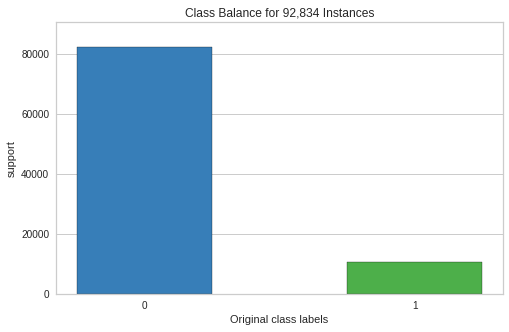

Counter({0: 82389, 1: 10445})


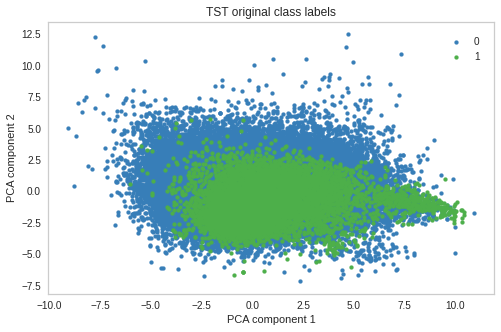

Counter({0: 82389, 1: 10445})


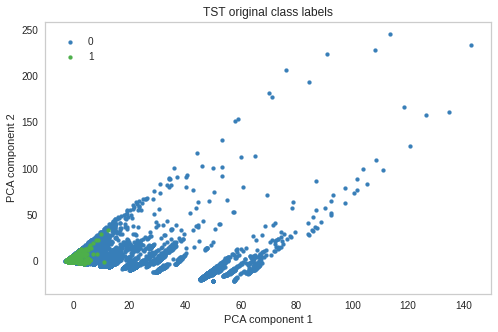

In [38]:
plot_class_balance(y_train, "Original class labels")

plot_examples_by_class_label(X_train, y_train, StandardScaler(), "")
plot_examples_by_class_label(X_train, y_train, RobustScaler(), "")

<h1>Undersampling</h1>

<h2>OSS (OneSidedSelection)</h2>
One-Sided Selection, or OSS for short, is an undersampling technique that combines **Tomek Links** and the **Condensed Nearest Neighbor** (CNN) Rule.

Specifically, Tomek Links are ambiguous points on the class boundary and are identified and removed in the majority class. The CNN method is then used to remove redundant examples from the majority class that are far from the decision boundary.

The CNN procedure occurs in one-step and involves first adding all minority class examples to the store and some number of majority class examples (e.g. 1), then classifying all remaining majority class examples with KNN (k=1) and adding those that are misclassified to the store.

N.B. Given that the CNN procedure occurs in one block, it is more useful to have a larger seed sample of the majority class in order to effectively remove redundant examples (i.e 200)
 into the store
</font>

**Default parameters**:
- sampling_strategy='auto',   # resample all classes but the majority class
- random_state=None, 
- n_neighbors=None, 
- n_seeds_S=1  # number of samples to extract in order to build the set S.

**Tuned parameters**:
- sampling_strategy = np.arange(0.1, 1.1, 0.1)*  
- random_state=42, 
- n_neighbors=range(1, sqrt_records*2),
- n_seeds_S=range(200,  y_tr[y_tr['album_type'] == 0].shape[0] , 200)

*number of samples in the minority class after resampling / number of samples in the majority class => desired ratio of the number of samples in the minority class over the number of samples in the majority class after resampling

In [39]:
def get_sampling_strategy_ratios():
    equality_ratio = y_tr[y_tr['album_type'] == 0].shape[0] - y_tr[y_tr['album_type'] == 1].shape[0]
    sampling_strategy = list(np.linspace(1000, equality_ratio, 10))
    ratios = []
    for new_majority_class in sampling_strategy:
        ratios.append({0: round(new_majority_class)})
    return ratios

In [40]:
def oss_grid(X_tr, y_tr):
    grid = model_grid(X_tr)
    sqrt_records = round(math.sqrt(X_tr.shape[0])) 
    # grid['imbalancer__sampling_strategy'] = get_sampling_strategy_ratios()
    grid['imbalancer__n_neighbors'] = list(range(1, sqrt_records*2))
    grid['imbalancer__n_seeds_S'] = list(range(200,  y_tr[y_tr['album_type'] == 0].shape[0], 200))
    return grid

In [41]:
imbalancer_name = 'OneSidedSelection'
imbalancer = OneSidedSelection(random_state=random_state, n_jobs=None)

<h6>Plain model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.771 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 40, 'model__min_samples_leaf': 2, 'model__max_features': 'log2', 'model__max_depth': 14, 'model__criterion': 'gini', 'model__class_weight': None, 'imbalancer__n_seeds_S': 40600, 'imbalancer__n_neighbors': 367} 


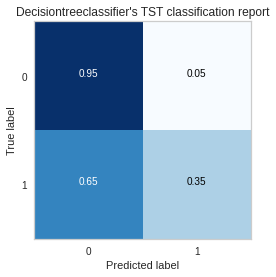

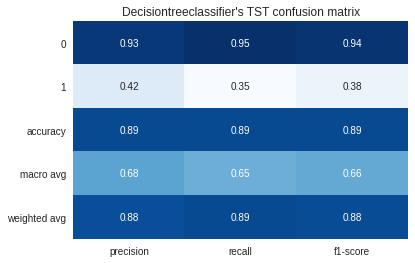

<Figure size 576x360 with 0 Axes>

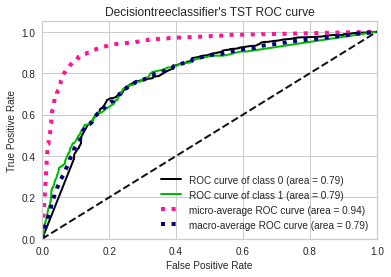

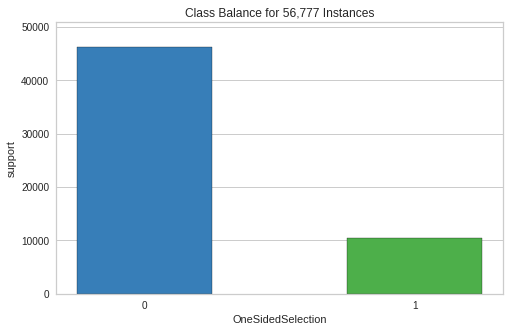

In [42]:
oss_params, oss_tuned_model, oss_y_pred, \
                oss_y_prob, oss_best_features = \
                                                    imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=oss_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h6>ANOVA model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.690 
Best Config: {'scaler': RobustScaler(), 'model__min_samples_split': 80, 'model__min_samples_leaf': 80, 'model__max_features': 'sqrt', 'model__max_depth': 35, 'model__criterion': 'entropy', 'model__class_weight': None, 'imbalancer__n_seeds_S': 43200, 'imbalancer__n_neighbors': 361, 'anova__k': 26} 


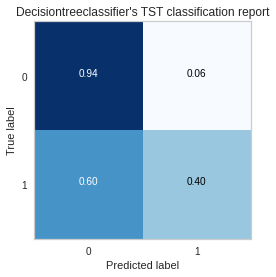

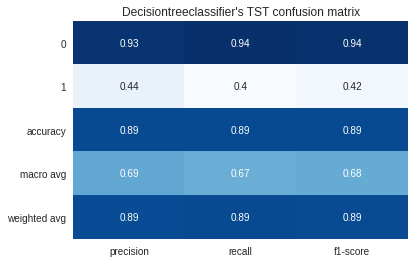

<Figure size 576x360 with 0 Axes>

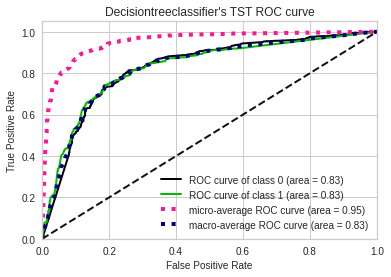

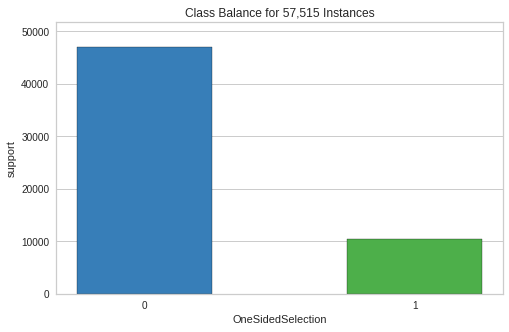

In [43]:
oss_params_anova, oss_tuned_model_anova, oss_y_pred_anova, \
                oss_y_prob_anova, oss_best_features_anova = \
                                                    imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=oss_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="anova", 
                                                                           feature_flag=True)

<h6>RFE model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.749 
Best Config: {'scaler': StandardScaler(), 'rfe__n_features_to_select': 39, 'rfe__estimator': LogisticRegression(max_iter=10000), 'model__min_samples_split': 40, 'model__min_samples_leaf': 30, 'model__max_features': 'log2', 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': 'balanced', 'imbalancer__n_seeds_S': 28000, 'imbalancer__n_neighbors': 159} 


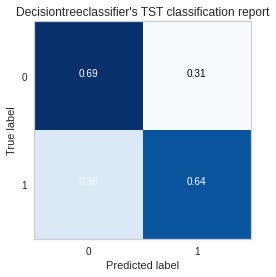

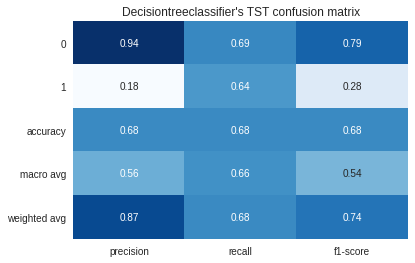

<Figure size 576x360 with 0 Axes>

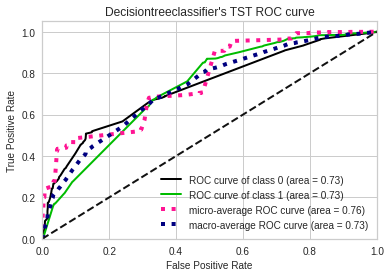

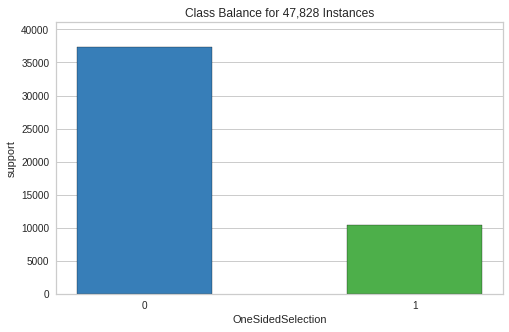

In [44]:
oss_params_rfe, oss_tuned_model_rfe, oss_y_pred_rfe, \
                oss_y_prob_rfe, oss_best_features_rfe = \
                                                    imbalanced_grid_search(
                                                                           X_tr=X_tr, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts, 
                                                                           y_ts=y_ts, 
                                                                           grid=oss_grid(X_tr, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="rfe", 
                                                                           feature_flag=True)

<h6>VarianceThreshold model</h6>

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.835 
Best Config: {'scaler': StandardScaler(), 'model__min_samples_split': 2, 'model__min_samples_leaf': 30, 'model__max_features': 'log2', 'model__max_depth': 2, 'model__criterion': 'entropy', 'model__class_weight': None, 'imbalancer__n_seeds_S': 12400, 'imbalancer__n_neighbors': 300} 


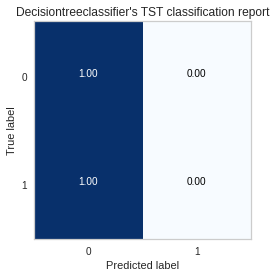

/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


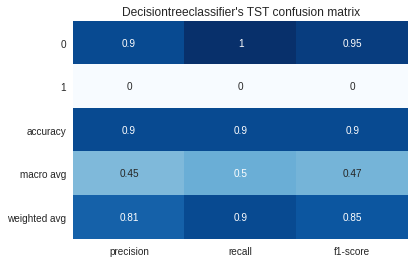

<Figure size 576x360 with 0 Axes>

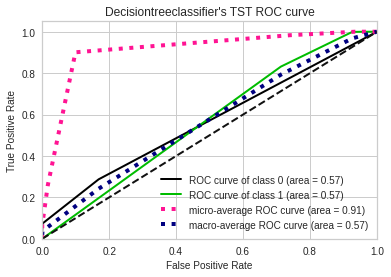

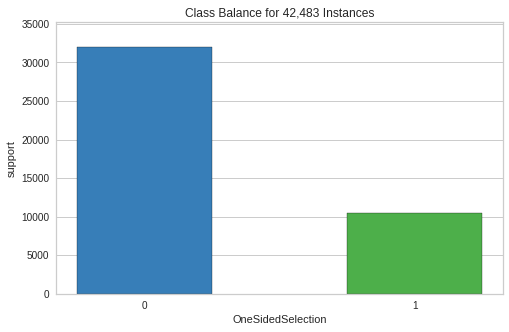

In [45]:
oss_params_vt, oss_tuned_model_vt, oss_y_pred_vt, \
                oss_y_prob_vt, oss_best_features_vt = \
                                                    imbalanced_grid_search(
                                                                           X_tr=X_tr_vt, 
                                                                           y_tr=y_tr, 
                                                                           X_ts=X_ts_vt, 
                                                                           y_ts=y_ts, 
                                                                           grid=oss_grid(X_tr_vt, y_tr), 
                                                                           imbalancer=imbalancer,
                                                                           imbalancer_name=imbalancer_name,
                                                                           scaler_flag=True, 
                                                                           feature_filter_key="", 
                                                                           feature_flag=True)

<h6> Saving best model on file </h6>

In [49]:
import pickle

model_info = {'model_name': "ANOVA",
              'params': oss_params_anova,
              'tuned_model': oss_tuned_model_anova,
              'y_pred': oss_y_pred_anova,
              'y_prob': oss_y_prob_anova,
              'best_features': oss_best_features_anova,
              # 'best_features_scores': oss__best_features_score_anova
             }

with open('pickle/' + model_name + '_oss_anova.pickle', 'wb') as handle:
    pickle.dump(model_info, handle, protocol=pickle.HIGHEST_PROTOCOL)